In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import

In [ ]:
%%capture
!pip3 install https://github.com/explosion/spacy-models/releases/download/it_core_news_sm-3.2.0/it_core_news_sm-3.2.0.tar.gz
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0.tar.gz
!pip install unidecode
!pip install emoji

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from bs4 import BeautifulSoup
import nltk
import unidecode
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import emoji
import re
import requests
from tqdm import tqdm
import random
import string
import matplotlib.pyplot as plt

In [ ]:
#Downloads for stopwords and punctuation
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('italian')
stopwords_english = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def get_statistics(data):
  num_words = 0
  vocab = set()
  description_data = list(data)
  representation_used = []
  docs_len = np.empty([len(description_data)])
  for i,d in enumerate(description_data):
    words = d.split()
    num_words += len(words)
    vocab.update(words)
    docs_len[i] = len(words)

  mean = np.mean(docs_len)
  std = np.std(docs_len)
  var = np.var(docs_len)
  min = np.min(docs_len)
  max = np.max(docs_len)

  dim_vocab = len(vocab)
  print("Number of words: {}\nDimension of the vocabulary: {}\nMean number of words: {}\nStandard deviation: {}\nVariance: {}\nMin number of words: {}\nMax number of words: {}\n".format(num_words, dim_vocab, mean, std, var, min, max))

  # matplotlib histogram
  plt.hist(docs_len, color = 'blue', edgecolor = 'black',
          bins = int(180/5), log=True)

  plt.title('Histogram of number of words')
  plt.xlabel('Number of words')
  plt.ylabel('Number of docs')
  plt.show()

# Easytour

## Import data

In [ ]:
# likes_path = "easytour-likes-2022-03MAR-21.json"
# schede_path = "easytour-schede-2022-03MAR-21.json"
#likes_path = "kuriu-likes-apr.json"
#schede_path = "kuriu-schede-apr.json"
likes_path = "/content/drive/MyDrive/Tesi/kuriu-likes-2022-06JUN-18.json"
schede_path = "/content/drive/MyDrive/Tesi/kuriu-schede-2022-06JUN-18.json"
data_path = "/content/drive/MyDrive/Tesi/data-JUN.csv"
data_path_no_stemming = "/content/drive/MyDrive/Tesi/data-JUN-no-stemming.csv"
data_analyzed_path = "/content/drive/MyDrive/Tesi/data_analyzed-JUN.csv"

In [ ]:
f_schede = open(schede_path)
data_schede = json.load(f_schede)
print("Fields: {}".format(data_schede[0].keys())) 
print("Number of samples: {}".format(len(data_schede)))

Fields: dict_keys(['id', 'userId', 'userName', 'documentType', 'title', 'description', 'locations', 'duration', 'imageId', 'previewId', 'distance', 'datePublishing', 'widgets', 'counters', 'features', 'tags', 'numberOfPositions', 'categories', 'videoId', 'creationDate', 'version', 'media', 'shareType', 'status', 'lastUpdate', 'versionHistory', 'viewCounter', 'device', 'crowdPosting', 'activeCrowdPosting'])
Number of samples: 5724


In [ ]:
print("First sample: {}".format(data_schede[8]))

First sample: {'id': '621128704f9d177c90f36d8a', 'userId': 579, 'userName': 'laviadellescimmie', 'documentType': 'experience', 'title': 'The Lion Rock, l’antica città di Sigiriya', 'description': 'Una delle attrazioni più suggestive di tutto lo Sri Lanka è la Lion Rock. Questa si trova all’interno di un parco chiamato Sigiriya. Si tratta di un’enorme roccia che svetta sulla vallata, immersa nella vegetazione. Si parla anche dell’antica città di Sigiriya perché sulla sua sommità si possono ancora ammirare le rovine di un antico palazzo (della fine del V secolo) e le zone coltivate. Sigiriya rientra nei patrimoni dell’umanità dello Sri Lanka. \n\nPer evitare di imbattersi in un gran numero di turisti, è meglio visitare il sito archeologico alla mattina, all’apertura. La luce è migliore, il clima è clemente e ci sono meno persone. La roccia deriva dall’erosione di un antico vulcano, ecco perché la sua forma è così particolare e unica in tutto il Paese. La roccia si trova su una collina al

In [ ]:
f_likes = open(likes_path)
data_likes = json.load(f_likes)
print("Number of samples: {}".format(len(data_likes)))
print("Fields: {}".format(data_likes[0].keys()))
print("First sample: {}".format(data_likes[0]))

Number of samples: 2542
Fields: dict_keys(['documentId', 'lastUpdate', 'authorId', 'userName', 'type'])
First sample: {'documentId': '622c3b8ac992ca28f33c7f21', 'lastUpdate': '2022-03-19T07:56:20.868Z', 'authorId': 606, 'userName': 'DaleOnTravel', 'type': 'Useful'}


In [ ]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)

## Data Analysis

In [ ]:
df_schede.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5724 non-null   object 
 1   userId              5724 non-null   int64  
 2   userName            5724 non-null   object 
 3   documentType        5724 non-null   object 
 4   title               5724 non-null   object 
 5   description         5724 non-null   object 
 6   locations           5724 non-null   object 
 7   duration            5724 non-null   int64  
 8   imageId             5723 non-null   object 
 9   previewId           598 non-null    object 
 10  distance            5724 non-null   int64  
 11  datePublishing      5713 non-null   object 
 12  widgets             4788 non-null   object 
 13  counters            5724 non-null   object 
 14  features            5724 non-null   object 
 15  tags                5724 non-null   object 
 16  number

In [ ]:
df_schede.describe()

,userId,duration,distance,numberOfPositions,version,viewCounter,crowdPosting
count,5724.000000,5.724000e+03,5724.0,5724.000000,5724.000000,5724.000000,0.0
mean,458.611286,1.848888e+07,0.0,1.300314,6.140985,41.306953,NaN
std,151.017776,6.209633e+07,0.0,1.000328,9.479419,42.832072,NaN
min,77.000000,0.000000e+00,0.0,1.000000,2.000000,1.000000,NaN
25%,314.000000,0.000000e+00,0.0,1.000000,3.000000,15.000000,NaN
50%,498.000000,3.600000e+06,0.0,1.000000,4.000000,45.000000,NaN
75%,572.500000,1.080000e+07,0.0,1.000000,7.000000,59.000000,NaN
max,708.000000,1.296000e+09,0.0,12.000000,414.000000,2134.000000,NaN


In [ ]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   documentId  2542 non-null   object
 1   lastUpdate  2542 non-null   object
 2   authorId    2542 non-null   int64 
 3   userName    2542 non-null   object
 4   type        2542 non-null   object
dtypes: int64(1), object(4)
memory usage: 99.4+ KB


In [ ]:
#df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "categories", "viewCounter"]]
#df_likes_ids = df_likes[["id", "userId"]]
df_likes_ids = df_likes[["documentId", "authorId"]]

In [ ]:
df_schede_fields

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,[Viaggi],18
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,[Viaggi],16
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,[Viaggi],426
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,[Viaggi],6
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,[Viaggi],424
...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,[Viaggi],47
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,[Aria aperta],95
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,[Cultura],63
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,[Viaggi],7


In [ ]:
easytour_processed = pd.read_csv(data_path_no_stemming)

In [ ]:
easytour_processed

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,Unnamed: 9,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,['Viaggi'],18,0,...,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,174
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,['Viaggi'],16,0,...,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,174
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,['Viaggi'],426,0,...,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,206
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,['Viaggi'],6,0,...,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,155
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,['Viaggi'],424,0,...,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,['Viaggi'],47,0,...,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,199
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,['Aria aperta'],95,0,...,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,240
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,['Cultura'],63,0,...,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,238
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,['Viaggi'],7,0,...,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,127


Number of words: 1556416
Dimension of the vocabulary: 138095
Mean number of words: 271.9105520614955
Standard deviation: 159.26735222054464
Variance: 25366.08948334303
Min number of words: 1.0
Max number of words: 1381.0



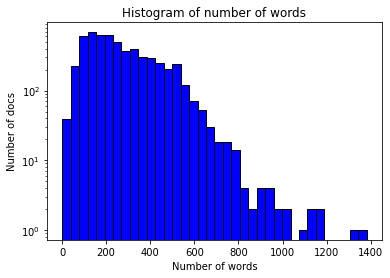

Number of words: 419867
Dimension of the vocabulary: 35354
Mean number of words: 73.35202655485675
Standard deviation: 45.411657863342406
Variance: 2062.2186698972682
Min number of words: 1.0
Max number of words: 438.0



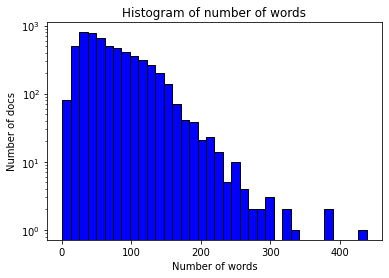

In [ ]:
get_statistics(df_schede_fields.description)
get_statistics(easytour_processed.description_processed)

## Preprocessing

### Null or empty values

In [ ]:
#Check if there are null fields
df_schede_fields.isnull().sum()

id                 0
userId             0
title              0
description        0
duration           0
datePublishing    11
creationDate       0
categories         1
viewCounter        0
dtype: int64

In [ ]:
def fill_null_fields(df):
    #empty description -> remove or use '' ?
    df["description"].fillna('', inplace=True)
    #if duration is null -> set to 0
    df["duration"].fillna(0, inplace=True)
    #if datePublishing is null -> set it equal to creationDate
    df["datePublishing"].fillna(df_schede_fields.creationDate, inplace=True)
    #if viewCounter is null -> set to 0
    df["viewCounter"].fillna(0, inplace=True)

In [ ]:
fill_null_fields(df_schede_fields)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Categories into one hot encoding

In [ ]:
def lower_list(l):
    if type(l)!=list:
        return []
    res = [x.lower() for x in l]
    return res

def encoding_categories(df):
  one_hot_enc_categories = df["categories"].apply(lambda x: lower_list(x))
  df["categories_encoding"] = one_hot_enc_categories
  mlb = MultiLabelBinarizer()

  schede_with_categories = df.join(
              pd.DataFrame(
                  mlb.fit_transform(df.pop('categories_encoding')),
                  index=df.index,
                  columns=mlb.classes_))
  return schede_with_categories

In [ ]:
df_categories = encoding_categories(df_schede_fields)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Text fields

In [ ]:
nlp = spacy.load("it_core_news_sm")

def keep_just_nouns(field):
    doc = nlp(field.lower())
    return [token.lemma_ for token in doc if token.pos_=="NOUN"]

def remove_verbs_adj(field):
    doc = nlp(field.lower())
    return [token.lemma_ for token in doc if token.pos_ not in ["VERB", "ADJ", "ADV"]]

In [ ]:
def demojize(field):
    try:
        result = emoji.demojize(field)
    except:
        result = field
    return result

In [ ]:
pat_hashtags = re.compile(r"#(\w+)")
def remove_hashtags(field):
    description = str(field).replace('\n', ' ').replace('description_end', ' ').strip().lower()

    # remove hashtags
    hashtags = list(set(pat_hashtags.findall(description)))
    hashtags = sorted(hashtags, key=lambda x: len(x), reverse=True)
    for hashtag in hashtags:
        description = description.replace('#' + hashtag, '')

    return description.replace('#', '').strip()

In [ ]:
def remove_punctuation(field):
  new_field = field.translate(str.maketrans('', '', string.punctuation))
  return new_field

In [ ]:
italian_stemmer = SnowballStemmer('italian')

def clean_text_aslist(field, stemm=False):
    no_hashtags = remove_hashtags(field)
    description = remove_punctuation(no_hashtags)

    token_list = []
    doc = nlp.tokenizer(description.replace("'", ' ').replace("’", ' ').lower())
    for token in doc:
        if not token.is_stop \
                and not token.is_punct \
                and not str(token) in stopwords \
                and not str(token).isdigit() \
                and not len(str(token).strip()) <= 2 \
                and not "\\" in str(token) \
                and not str(token) == len(str(token)) * str(token)[0]: #remove tokens composed by just one character, e.g. 'aaaa'
            if stemm==True:
              token_list.append(italian_stemmer.stem(str(token)))
            else:
              token_list.append(str(token))

    return token_list

In [ ]:
def clean_text(df):
    df["title_processed"] = df["title"].apply(lambda x: demojize(x))
    df["description_processed"] = df["description"].apply(lambda x: demojize(x))
    # Remove Verbs from description
    schede_description = df.apply(
        lambda row: remove_verbs_adj(row['description']),
        axis=1)

    # Remove hastags, punctuation, stop words and numbers
    schede_description = schede_description.apply(
        lambda row: clean_text_aslist(row)) 
        
    # Remove verbs from title
    schede_title = df.apply(
        lambda row: remove_verbs_adj(row['title']),
        axis=1)
        
    # Remove hastags, punctuation, stop words and numbers
    schede_title = schede_title.apply(
        lambda row: clean_text_aslist(row))
    
    df["description_processed"] = schede_description
    df["title_processed"] = schede_title

In [ ]:
clean_text(df_categories)

In [ ]:
df_categories

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,,...,eventi culinari,food,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,[Viaggi],18,0,...,0,0,0,0,0,0,0,1,"[big, buddha]","[meta, turista, assalto, spiaggia, acqua, mera..."
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,[Viaggi],16,0,...,0,0,0,0,0,0,0,1,"[wat, chalong, tempio, phuket]","[spiaggia, pena, tempio, wat, chalong, big, bu..."
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,[Viaggi],426,0,...,0,0,0,0,0,0,0,1,[tigre],"[marcio, maltrattamento, animale, andare, scon..."
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,[Viaggi],6,0,...,0,0,0,0,0,0,0,1,"[capitale, myanmar]","[punto, inizio, viaggio, myanmar, pregio, dife..."
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,[Viaggi],424,0,...,0,0,0,0,0,0,0,1,[beach],"[spiaggia, isola, phuket, freedom, beach, spia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,[Viaggi],47,0,...,0,0,0,0,0,0,0,1,"[picchu, meraviglia]","[alba, realtà, viaggio, rumore, cascata, capel..."
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,[Aria aperta],95,0,...,0,0,0,0,0,0,0,0,"[segreto, moray]","[prova, esistenza, alieno, realtà, studio, ter..."
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,[Cultura],63,0,...,0,0,0,0,0,0,0,0,"[picchu, storia, meraviglia]","[dieci, esperienza, machu, ricordo, memoria, s..."
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,[Viaggi],7,0,...,0,0,0,0,0,0,0,1,"[machu, picchu, modalità]","[argomento, meraviglia, ebbene, realtà, inca, ..."


### Dates

In [ ]:
def preprocess_dates(df):
    # Convert duration from ms to minutes
    df['duration_min'] = df.apply(lambda row: row["duration"] / 60000, axis=1)

    # Compute age of entry in days from today
    df['days'] = 0
    df.days = (pd.to_datetime("now").tz_localize('UTC') - pd.to_datetime(
        df["creationDate"])) // np.timedelta64(1, 'D')

In [ ]:
preprocess_dates(df_categories)

In [ ]:
df_categories

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,[Viaggi],18,0,...,0,0,0,0,0,1,"[big, buddha]","[meta, turista, assalto, spiaggia, acqua, mera...",0.0,174
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,[Viaggi],16,0,...,0,0,0,0,0,1,"[wat, chalong, tempio, phuket]","[spiaggia, pena, tempio, wat, chalong, big, bu...",0.0,174
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,[Viaggi],426,0,...,0,0,0,0,0,1,[tigre],"[marcio, maltrattamento, animale, andare, scon...",180.0,206
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,[Viaggi],6,0,...,0,0,0,0,0,1,"[capitale, myanmar]","[punto, inizio, viaggio, myanmar, pregio, dife...",0.0,155
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,[Viaggi],424,0,...,0,0,0,0,0,1,[beach],"[spiaggia, isola, phuket, freedom, beach, spia...",300.0,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,[Viaggi],47,0,...,0,0,0,0,0,1,"[picchu, meraviglia]","[alba, realtà, viaggio, rumore, cascata, capel...",360.0,199
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,[Aria aperta],95,0,...,0,0,0,0,0,0,"[segreto, moray]","[prova, esistenza, alieno, realtà, studio, ter...",120.0,240
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,[Cultura],63,0,...,0,0,0,0,0,0,"[picchu, storia, meraviglia]","[dieci, esperienza, machu, ricordo, memoria, s...",270.0,238
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,[Viaggi],7,0,...,0,0,0,0,0,1,"[machu, picchu, modalità]","[argomento, meraviglia, ebbene, realtà, inca, ...",0.0,127


### Save results

In [ ]:
df_categories.to_csv(data_path_no_stemming, index=False)

In [ ]:
data = pd.read_csv(data_path_no_stemming)  

In [ ]:
data

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,Unnamed: 9,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,['Viaggi'],18,0,...,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,174
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,['Viaggi'],16,0,...,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,174
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,['Viaggi'],426,0,...,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,206
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,['Viaggi'],6,0,...,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,155
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,['Viaggi'],424,0,...,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,['Viaggi'],47,0,...,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,199
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,['Aria aperta'],95,0,...,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,240
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,['Cultura'],63,0,...,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,238
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,['Viaggi'],7,0,...,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,127


<h3>Preprocess using functions in support</h3>

In [ ]:
#analyze.analyze_dataset(schede_path, data_analyzed_path, [])

##User/likes distribution

In [ ]:
likes_path = "/content/drive/MyDrive/Tesi/kuriu-likes-2022-06JUN-18.json"
schede_path = "/content/drive/MyDrive/Tesi/kuriu-schede-2022-06JUN-18.json"
#data_path = "/content/drive/MyDrive/Tesi/data-JUN.csv"
data_path = "/content/drive/MyDrive/Tesi/data-JUN-no-stemming.csv"
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
categories = ["aria aperta", "cultura",	"eventi culinari", "food", "food all'aperto", "food drink",	"sport",	"tempo libero", "travel",	"viaggi"]
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "categories", "viewCounter"]]
df_likes_ids = df_likes[["documentId", "authorId"]]

In [ ]:
data = pd.read_csv(data_path, encoding_errors='ignore')  

In [ ]:
df_likes_ids.authorId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
2        True
4        True
5        True
        ...  
2252    False
2312     True
2415     True
2447     True
2488     True
Name: authorId, Length: 123, dtype: bool

In [ ]:
#list of users, some ids in likes are not in posts -> some users liked posts but not posted one
users = pd.concat([df_likes_ids.authorId, data.userId]).drop_duplicates() 
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
#list of posts and users that liked that post
posts_with_likes = df_likes_ids.groupby("documentId").authorId.apply(list)
#list of users and posts they liked
users_with_likes = df_likes_ids.groupby("authorId").documentId.apply(list)
#users that have not posted anything
users_without_posts = users[~users.isin(users_posts.index)].values
#users that did not like any posts
users_without_likes_made = users[~users.isin(users_with_likes.index)].values
#posts that did not receive any likes
posts_without_likes = posts[~posts.isin(posts_with_likes.index)].values

print("Total number of users: {}".format(len(users)))
print("Number of posts: {}".format(len(posts)))
print("Number of users that posted something: {}".format(len(users_posts)))
print("Number of posts that received likes: {}".format(len(posts_with_likes)))
print("Total number of likes: {}".format(posts_with_likes.str.len().sum())) 
print("Number of users that liked posts: {}".format(len(users_with_likes)))
print("Number of users that not posted anything: {}".format(len(users_without_posts)))
print("Number of users that not liked anything: {}".format(len(users_without_likes_made)))
print("Number of posts that not received likes: {}".format(len(posts_without_likes)))

Total number of users: 187
Number of posts: 5724
Number of users that posted something: 156
Number of posts that received likes: 1708
Total number of likes: 2542
Number of users that liked posts: 123
Number of users that not posted anything: 31
Number of users that not liked anything: 64
Number of posts that not received likes: 4016


In [ ]:
data_with_ids = data.drop(columns=["datePublishing", "categories", "creationDate", "duration", "description", "title", "viewCounter"])

In [ ]:
#"duration_min", "days"
X = data.drop(columns=["id", "userId","Unnamed: 9", "description", "description_processed","categories", "title", "title_processed", "datePublishing", "creationDate", "duration", "viewCounter"])

In [ ]:
X

,aria aperta,cultura,eventi culinari,food,food all'aperto,food drink,sport,tempo libero,travel,viaggi,duration_min,days
0,0,0,0,0,0,0,0,0,0,1,0.0,174
1,0,0,0,0,0,0,0,0,0,1,0.0,174
2,0,0,0,0,0,0,0,0,0,1,180.0,206
3,0,0,0,0,0,0,0,0,0,1,0.0,155
4,0,0,0,0,0,0,0,0,0,1,300.0,206
...,...,...,...,...,...,...,...,...,...,...,...,...
5719,0,0,0,0,0,0,0,0,0,1,360.0,199
5720,1,0,0,0,0,0,0,0,0,0,120.0,240
5721,0,1,0,0,0,0,0,0,0,0,270.0,238
5722,0,0,0,0,0,0,0,0,0,1,0.0,127


In [ ]:
data

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,Unnamed: 9,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,['Viaggi'],18,0,...,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,174
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,['Viaggi'],16,0,...,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,174
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,['Viaggi'],426,0,...,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,206
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,['Viaggi'],6,0,...,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,155
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,['Viaggi'],424,0,...,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,['Viaggi'],47,0,...,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,199
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,['Aria aperta'],95,0,...,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,240
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,['Cultura'],63,0,...,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,238
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,['Viaggi'],7,0,...,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,127


In [ ]:
df_schede

,id,userId,userName,documentType,title,description,locations,duration,imageId,previewId,...,version,media,shareType,status,lastUpdate,versionHistory,viewCounter,device,crowdPosting,activeCrowdPosting
0,62349ff2272ae5672fbc3135,632,Forestlife_Adventure,experience,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,[{'photoReference': 'Aap_uEA4LhCYzVzbaHBUWsYoz...,0,62349c0c272ae5672fbc30d6,None,...,5,{'photos': [{'fileId': '62349c0c272ae5672fbc30...,SHARED,PUBLISHED,2022-04-20T12:54:13.563Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",18,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
1,6234aa65272ae5672fbc34c2,632,Forestlife_Adventure,experience,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",[{'photoReference': 'Aap_uEDR-tkPt3POWYoKoWcHy...,0,6234a758272ae5672fbc32aa,None,...,5,{'photos': [{'fileId': '6234a758272ae5672fbc32...,SHARED,PUBLISHED,2022-04-20T12:54:13.586Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",16,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
2,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,10800000,620aa384ff8ae67f37cafaf9,None,...,7,{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",426,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
3,624e5982ec9ff859ff529ce8,571,tiportoviaconme,experience,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,[{'photoReference': 'Aap_uEDCSLsqxhvyp9pUEmR5R...,0,624e5916ec9ff859ff529c90,None,...,3,{'photos': [{'fileId': '624e5916ec9ff859ff529c...,SHARED,PUBLISHED,2022-04-07T03:24:50.535Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",6,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A...",NaN,False
4,620abb33ff8ae67f37cafe3c,442,lollo_cata,experience,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,[{'photoReference': 'Aap_uECP3iO80ReEkce8JB_2s...,18000000,620ab9e4ff8ae67f37cafe30,None,...,8,{'photos': [{'fileId': '620ab9e4ff8ae67f37cafe...,SHARED,PUBLISHED,2022-02-14T20:27:31.966Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",424,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,Elle_,experience,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",[{'photoReference': 'Aap_uEASvi2g7Xd91-_ojmvmi...,21600000,6213b3000f41f86438b07cad,None,...,6,{'photos': [{'fileId': '6213b3000f41f86438b07c...,SHARED,PUBLISHED,2022-04-22T14:14:59.961Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",47,"{'deviceModel': 'iPhone 8', 'deviceOS': 'iOS',...",NaN,False
5720,61dd867f9c823e129b1f2cc2,429,Elle_,experience,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,[{'photoReference': 'Aap_uEBZ0EHCQ9HgiQWe89I7L...,7200000,61dd860e9c823e129b1f2c7b,None,...,6,{'photos': [{'fileId': '61dd860e9c823e129b1f2c...,SHARED,PUBLISHED,2022-04-22T14:14:59.815Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",95,None,NaN,False
5721,61e0146111b3bf4d3185ad5d,427,teretacchi,experience,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,[{'photoReference': 'Aap_uECe7KHh6UtQvIdb8g3JL...,16200000,61e0134011b3bf4d3185ad2f,None,...,6,{'photos': [{'fileId': '61e0134011b3bf4d3185ad...,SHARED,PUBLISHED,2022-01-13T12:04:33.749Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",63,None,NaN,False
5722,6273a0a9dd67f6198e5ac192,606,DaleOnTravel,experience,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,[{'photoReference': 'Aap_uEBtY1EzLnQqBMoci7nIs...,0,6273a0a7dd67f6198e5ac165,6273a03add67f6198e5ac12c,...,2,{'photos': [{'fileId': '6273a0a7

# Tourpedia

## Import and analysis

In [ ]:
tourpedia_dataset = "/content/drive/MyDrive/Tesi/tourpedia.csv"
tourpedia_dataset_preprocessed = "/content/drive/MyDrive/Tesi/tourpedia_preprocessed.csv"

In [ ]:
data_tourpedia = pd.read_csv(tourpedia_dataset)  

In [ ]:
data_tourpedia

,id,language,description,rating,time
0,0,en,"Not tried the hostel but the weed is bang on, ...",5.0,1362671792
1,1,en,"""Thank you for being part of the..."" on Miz De...",NaN,1361644378
2,2,en,"Enjoy the entire venue while you're there, not...",0.0,1315221471
3,3,en,Great restaurant with simple but delicious foo...,0.0,1382122410
4,4,en,This place is mandatory every time we come to ...,0.0,1349085680
...,...,...,...,...,...
7995,995,en,Fantastic friendly welcome. Good food. Central...,4.0,1354834145
7996,996,en,The lack of service and quality is astounding....,0.0,1305284273
7997,997,en,"ice cream is good; on the other side, whipped ...",0.0,1328993248
7998,998,en,Special carnival dishes for the evening of the...,0.0,1329484353


In [ ]:
data_tourpedia_proc = pd.read_csv(tourpedia_dataset_preprocessed)

In [ ]:
data_tourpedia_proc

,id,language,description,rating,time,description_processed
0,0,en,"Not tried the hostel but the weed is bang on, ...",5.0,1362671792,"['hostel', 'weed', 'bang', 'looking', 'place',..."
1,1,en,"""Thank you for being part of the..."" on Miz De...",NaN,1361644378,"['miz', 'dee', 'logwood', 'post', 'club', 'dau..."
2,2,en,"Enjoy the entire venue while you're there, not...",0.0,1315221471,"['venue', 'event']"
3,3,en,Great restaurant with simple but delicious foo...,0.0,1382122410,"['restaurant', 'food', 'reservation', 'place']"
4,4,en,This place is mandatory every time we come to ...,0.0,1349085680,"['place', 'time', 'amsterdam', 'burger', 'neth..."
...,...,...,...,...,...,...
7995,995,en,Fantastic friendly welcome. Good food. Central...,4.0,1354834145,"['welcome', 'food', 'location']"
7996,996,en,The lack of service and quality is astounding....,0.0,1305284273,"['lack', 'service', 'quality', 'kid', 'way']"
7997,997,en,"ice cream is good; on the other side, whipped ...",0.0,1328993248,"['ice', 'cream', 'cream', 'chocolate', 'aftert..."
7998,998,en,Special carnival dishes for the evening of the...,0.0,1329484353,"['carnival', 'dish', 'evening', 'february']"


Statistics for raw data
Number of words: 191996
Dimension of the vocabulary: 27012
Mean number of words: 23.9995
Standard deviation: 37.36601396657128
Variance: 1396.21899975
Min number of words: 1.0
Max number of words: 692.0



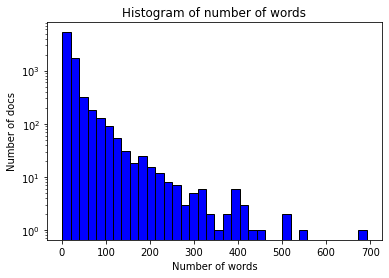

Statistics for preprocessed data
Number of words: 53356
Dimension of the vocabulary: 12098
Mean number of words: 6.6695
Standard deviation: 9.047735614505987
Variance: 81.86151975000001
Min number of words: 1.0
Max number of words: 151.0



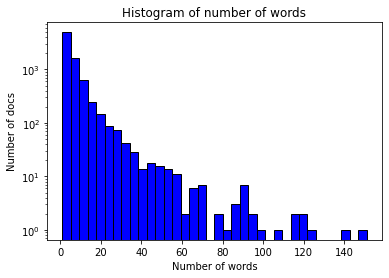

In [ ]:
print("Statistics for raw data")
get_statistics(data_tourpedia.description)
print("Statistics for preprocessed data")
get_statistics(data_tourpedia_proc.description_processed)

## Download data

In [ ]:
locations = ["Amsterdam", "Barcelona", "Berlin", "Dubay", "London", "Paris", "Rome", "Tuscany"]
fields = ["language", "text", "rating", "time"]

In [ ]:
URL = "https://wafi.iit.cnr.it/openervm/api/getReviews?language=en&location="

In [ ]:
def build_dataset(url, locations, fields):
  reviews_list = []
  for l in locations:
    print("Scraping reviews for the following city: {}".format(l))
    #get html page
    url_location = url + l
    page = requests.get(url_location)
    p_reviews = page.text #remove square brackets in the beginning and end of text
    p_reviews = p_reviews[1:-1]
    #get single reviews
    p_reviews_splitted = p_reviews.split("},")
    len_reviews = len(p_reviews_splitted)
    for i in range(0,len_reviews-1):
      p_reviews_splitted[i] = p_reviews_splitted[i] + "}"

    #transform reviews in json from string
    list_json_reviews = []
    for r in p_reviews_splitted:
      try:
        list_json_reviews.append(json.loads(r))
      except:
        #some reviews are bad-shaped
        print("This review has not a right format")
        continue
    
    #Choose 1000 reviews at random
    if len_reviews > 1000:
      random_reviews = random.sample(list_json_reviews, 1000)

    #Build entries 
    print("Building 1000 entries from the original {} for {}...".format(len_reviews, l))
    for id in tqdm(range(0,1000)):
      details = random_reviews[id].get("details")
      p = requests.get(details)
      try:
        j_details = json.loads(p.text)
      except:
        #some reviews are bad-shaped
        print("This review has not a right format")
        continue
      attributes = [id]
      for f in fields:
        attributes.append(j_details.get(f))
      reviews_list.append(attributes)
  #Build dataframe
  columns = ["id"] + fields
  tourpedia_reviews = pd.DataFrame(reviews_list, columns=columns)
  tourpedia_reviews.rename(columns = {'text':'description'}, inplace = True)
  return tourpedia_reviews

In [ ]:
# tourpedia_reviews = build_dataset(URL, locations, fields)
# print(len(tourpedia_reviews))
# tourpedia_reviews.to_csv(tourpedia_dataset, index=False)

In [ ]:
#tourpedia_reviews

## Preprocessing

In [ ]:
nlp = spacy.load("en_core_web_sm")

def keep_just_nouns(field):
    doc = nlp(field.lower())
    return [token.lemma_ for token in doc if token.pos_=="NOUN"]

def remove_verbs_adj(field):
    doc = nlp(field.lower())
    return [token.lemma_ for token in doc if token.pos_ not in ["VERB", "ADJ", "ADV"]]

In [ ]:
def demojize(field):
    try:
        result = emoji.demojize(field)
    except:
        result = field
    return result

In [ ]:
pat_hashtags = re.compile(r"#(\w+)")

def remove_hashtags(field):
    description = str(field).replace('\n', ' ').replace('description_end', ' ').strip().lower()

    # remove hashtags
    hashtags = list(set(pat_hashtags.findall(description)))
    hashtags = sorted(hashtags, key=lambda x: len(x), reverse=True)
    for hashtag in hashtags:
        description = description.replace('#' + hashtag, '')

    return description.replace('#', '').strip()

In [ ]:
def remove_punctuation(field):
  new_field = field.translate(str.maketrans('', '', string.punctuation))
  return new_field

In [ ]:
def clean_text_aslist(field, stemm=False):
    no_hashtags = remove_hashtags(field)
    description = remove_punctuation(no_hashtags)

    token_list = []
    doc = nlp.tokenizer(description.replace("'", ' ').replace("’", ' ').lower())
    for token in doc:
        if not token.is_stop \
                and not token.is_punct \
                and not str(token) in stopwords_english \
                and not str(token).isdigit() \
                and not len(str(token).strip()) <= 2 \
                and not "\\" in str(token) \
                and not str(token) == len(str(token)) * str(token)[0]: #remove tokens composed by just one character, e.g. 'aaaa'
            token_list.append(str(token))

    return token_list

In [ ]:
def clean_text(df):
    df["description_processed"] = df["description"].apply(lambda x: demojize(x))
    # Remove Verbs from description
    reviews_processed = df.apply(
        lambda row: remove_verbs_adj(row['description_processed']),
        axis=1)

    # Remove hastags, punctuation, stop words and numbers
    reviews_processed = reviews_processed.apply(
        lambda row: clean_text_aslist(row)) 
    print(reviews_processed)
    df["description_processed"] = reviews_processed

In [ ]:
clean_text(data_tourpedia)

0       [hostel, weed, bang, looking, place, spot, sta...
1         [miz, dee, logwood, post, club, dauphine, wall]
2                                          [venue, event]
3                  [restaurant, food, reservation, place]
4       [place, time, amsterdam, burger, netherland, f...
                              ...                        
7995                            [welcome, food, location]
7996                   [lack, service, quality, kid, way]
7997           [ice, cream, cream, chocolate, aftertaste]
7998                  [carnival, dish, evening, february]
7999    [food, service, price, quality, food, atmosphe...
Length: 8000, dtype: object


In [ ]:
data_tourpedia

,id,language,description,rating,time,description_processed
0,0,en,"Not tried the hostel but the weed is bang on, ...",5.0,1362671792,"[hostel, weed, bang, looking, place, spot, sta..."
1,1,en,"""Thank you for being part of the..."" on Miz De...",NaN,1361644378,"[miz, dee, logwood, post, club, dauphine, wall]"
2,2,en,"Enjoy the entire venue while you're there, not...",0.0,1315221471,"[venue, event]"
3,3,en,Great restaurant with simple but delicious foo...,0.0,1382122410,"[restaurant, food, reservation, place]"
4,4,en,This place is mandatory every time we come to ...,0.0,1349085680,"[place, time, amsterdam, burger, netherland, f..."
...,...,...,...,...,...,...
7995,995,en,Fantastic friendly welcome. Good food. Central...,4.0,1354834145,"[welcome, food, location]"
7996,996,en,The lack of service and quality is astounding....,0.0,1305284273,"[lack, service, quality, kid, way]"
7997,997,en,"ice cream is good; on the other side, whipped ...",0.0,1328993248,"[ice, cream, cream, chocolate, aftertaste]"
7998,998,en,Special carnival dishes for the evening of the...,0.0,1329484353,"[carnival, dish, evening, february]"


In [ ]:
data_tourpedia.to_csv(tourpedia_dataset_preprocessed, index=False)